## Preference-based Policy Iteration (PBPI) Algorithm 
### Application on the Inverted pendulum problem
#### Demostrate the learned policy

----

In [3]:
########################################
### importing the necessary packages ###

import gym
from gym import wrappers

import numpy as np
import pandas as pd

from scipy.stats import rankdata as rd
from scipy import stats

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import TensorDataset, DataLoader

import matplotlib.pyplot as plt
from IPython import display
from IPython.display import HTML

import io
import base64
import itertools
import tqdm

import custom_cartpole

########################################

In [4]:
########################################
########## custom environment ##########

# # maximum length of a trajectory set to 1500 steps
# gym.envs.register(id='CartPole_PbPI_Version-v0'
#                   , entry_point='gym.envs.classic_control:CartPoleEnv'
#                   , max_episode_steps=1500)


########## helper functions ##########

# generate a random action from a given environment
def random_action(environment, seed=10):
    """ return a random action from the given environment. """
    
    # set env. seeds for reproducibility
    #environment.action_space.np_random.seed(seed) 
    #environment.seed(seed) 
    
    return environment.action_space.sample()


# generate a list of initial states from a given environment
def generate_init_states_S(seed
                           , env = 'CustomCartPole-v0'):
    """ this function returns a list of randomly generated initial states from a given environment. """
    
    # set the random seed for reproducibility
    np.random.seed(seed)
    
    # define how many states to generate
    n_states = np.random.randint(low=1, high=101) 

    # define a list to store the generated initial states
    init_states_S = []

    # create a given environment object
    env = gym.make(env)
    env.action_space.np_random.seed(seed) # set env. seeds for reproducibility
    env.seed(seed) # set env. seeds for reproducibility
    env.reset()

    # create initial states
    for _ in range(n_states):

        # step through the environment
        state, reward, done, info = env.step(env.action_space.sample())  
            
        # if terminates, reset the environment
        # and continue to next step (without appending to state list)
        # increment 'n_states' count by 1
        if done: 
            env.reset()
            n_states+=1
            
        # append the geneareted state to list
        # there are observations with different shape: this step skips them
        init_states_S.append(state)
      
    env.close()
            
    return init_states_S[:]


# partition the action space of a given environment 
def partition_action_space(env_name:'string'
                           , n_actions:'int'):
    """function to partitions the action space of an environment into a given number of actions`"""
    
    # initialize environment
    env = gym.make(env_name)

    # partition the action space to a given number of actions
    # - a uniform noise term is added to action signals to make all state transitions non-deterministic
    part_act_space = np.linspace(env.action_space.low[0,0]
                                 ,env.action_space.high[0,0],n_actions) + np.random.uniform(low = -.2,high=.2)
    
    return part_act_space  


########################################

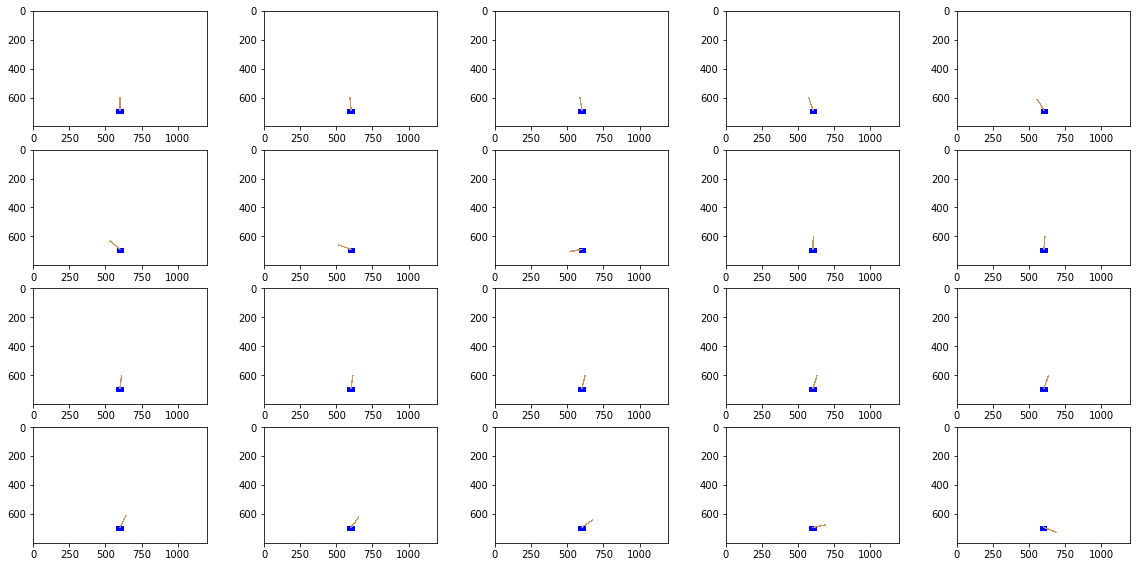

In [3]:
########################################
########### EXTRA : EXAMPLES ###########

# generate a list of sample states and plot 40 states
init_states_S = generate_init_states_S(4, env='CustomCartPole-v0')

env = gym.make('CustomCartPole-v0')
env = env.unwrapped # unwrap the environment to set custom initial states
fig = plt.figure(figsize=(20,20))

for i in range(20):
    env.state = init_states_S[i] # set state
    fig.add_subplot(8,5,i+1)
    plt.imshow(env.render(mode="rgb_array"))
    env.close()
    
plt.show()


########################################

In [4]:
########################################
### Derived policy using LabelRanker ###

class Policy():
    
    """
    Description:
    
        - This Policy object takes a given neural network (LabelRanker) model and uses it to define a policy for the agent to follow
    """
    
    def __init__(self, action_space, model):
        self.action_space = action_space # action space of the current environment
        self.model = model               # trained NN (LabelRanker) model
        
    def label_ranking_policy(self,obs):
        """ Produces an action for a given state based on the LabelRanker model prediction
            Note: only the pendulum-angle and pendulum-velocity of the input state are considered when producing an action
        
            At each input state:
                - Highest ranked action is selected with a prob. of 0.95
                - Second highest ranked action is selected with a prob. of 0.04
                - Any remaining actions are selected with an equal proabability of .01 """


        # only select the pendulum-velocity and angle from the input state vector
        state_obs = np.array([round(obs[2].reshape(-1)[0],2),round(obs[3].reshape(-1)[0],2)])       
        #state_obs = state_obs.reshape(-1,state_obs.shape[0]) # reshape to be a 2D array
        state_obs = torch.from_numpy(state_obs) # convert to a tensor

        # make ranking predictions for all actions
        with torch.no_grad():
            preds = self.model(state_obs.float()) 

        # rank the indexes of actions (from highest ranked/preferred action to lowest)
        #ranked_action_idx = (-rd(preds.detach().numpy())).argsort()[:preds.shape[1]]
        ranked_action_idx = (-rd(preds.detach().numpy())).argsort()

        
        ### return the selected action ###
        
        # if there are more than 2 actions
        if len(self.action_space)>2:
            
            # compute the probabilities for the 3rd action onward
            remain_probs = .05/len(ranked_action_idx[2:])
            n_remain_actions = ranked_action_idx.shape[0]-2

            # select first two (highest preferred actions) 95% and 4% of the time
            # select one of the remaining actions 1% time
            action = np.random.choice(ranked_action_idx,1 , p=[.90, 0.05] + list(np.repeat(remain_probs,n_remain_actions)))[0]
        
        else:
            
            # if there are only 2 actions: select highest preferred actions 95% and 5% of the time
            action = np.random.choice(ranked_action_idx,1 , p=[.90, 0.10])[0]
        
        # when action space is partitioned, return the corresponding action
        # clip action value to (-1,1) range
        return np.array([[np.clip(self.action_space[int(action)],-1,1)]])
    

########################################

In [22]:
state_string_li = []
for state in generate_init_states_S(1):
    state_string_li.append("".join([str(item[0]) for item in [item.reshape(-1) for item in state.flatten()]]))

In [31]:
uniq, u_idx = np.unique(state_string_li,return_index=True)

In [74]:
t = generate_init_states_S(1)

# remove any duplicate state values from the list
state_str_li = []
for state in t:
    state_str_li.append("".join([str(item[0]) for item in [item.reshape(-1) for item in state.flatten()]]))
    
uniq, u_idx = np.unique(state_str_li, return_index=True)

t = [t[j] for j in u_idx]


[array([[[-0.0157999 ]],
 
        [[-0.59087026]],
 
        [[-0.5168154 ]],
 
        [[-1.3331842 ]]], dtype=float32), array([[[-0.05454234]],
 
        [[-0.93128437]],
 
        [[ 0.03102599]],
 
        [[ 1.0927463 ]]], dtype=float32), array([[[-0.06776033]],
 
        [[ 0.02888881]],
 
        [[-1.7995656 ]],
 
        [[-6.3678265 ]]], dtype=float32), array([[[-0.07128489]],
 
        [[ 0.03524554]],
 
        [[-1.3043444 ]],
 
        [[-4.9522114 ]]], dtype=float32), array([[[-0.07488693]],
 
        [[-0.23094454]],
 
        [[-0.65013385]],
 
        [[-2.5289094 ]]], dtype=float32), array([[[-0.09798138]],
 
        [[ 0.2669649 ]],
 
        [[-0.9030248 ]],
 
        [[-4.013196  ]]], dtype=float32), array([[[-0.14767078]],
 
        [[-1.3647437 ]],
 
        [[ 0.14030062]],
 
        [[ 1.788223  ]]], dtype=float32), array([[[-0.28414515]],
 
        [[-1.7106469 ]],
 
        [[ 0.3191229 ]],
 
        [[ 2.5075455 ]]], dtype=float32), array([[[-0.45520985]],

---
#### Test the learned policy on random starting states

In [7]:
# create the environment and action space
seed = 4 
model_name = 'cartPole_original' # name for the LabelRanker model

env = gym.make('CustomCartPole-v0')   # environment
sample_states = generate_init_states_S(seed, env='CustomCartPole-v0') # initial state list
act_space = partition_action_space('CustomCartPole-v0',3) # action space

# define the model
class Model(nn.Module):

    def __init__(self, input_state_len, output_label_len, layers, p=0.3):

        super(Model,self).__init__()

        all_layers = []
        input_size = input_state_len

        # create layers
        for layer_dim in layers:
            all_layers.append(nn.Linear(input_size, layer_dim))
            all_layers.append(nn.LeakyReLU(inplace=True))
            #all_layers.append(nn.BatchNorm1d(layer_dim))
            all_layers.append(nn.Dropout(p))
            input_size = layer_dim

        all_layers.append(nn.Linear(layers[-1], output_label_len))

        self.layers = nn.Sequential(*all_layers)

    def forward(self, state_vec):
        x = self.layers(state_vec)
        return x

input_size  = 2
output_size = len(act_space)
mod_layers = [50]
model = Model(input_size, output_size, mod_layers)
        
# load the model
PATH = f"./models/{model_name}_pbpi_model.pt" 
model.load_state_dict(torch.load(PATH))
model.eval()

# create policy
policy = Policy(act_space,model)

# apply policy and record frames
env = wrappers.Monitor(env, "./gym-results", force=True)
obs = env.reset()
#env.state = env.reset()

for _ in range(1000):
    action = policy.label_ranking_policy(obs)
    observation, reward, done, info = env.step(action)
    obs = observation
    if done: break
env.close()

# observe policy performance
video = io.open('./gym-results/openaigym.video.%s.video000000.mp4' % env.file_infix, 'r+b').read()
encoded = base64.b64encode(video)
HTML(data='''
    <video width="360" height="auto" alt="test" controls><source src="data:video/mp4;base64,{0}" type="video/mp4" /></video>'''
.format(encoded.decode('ascii')))

#### Test the learned policy on the initial starting states

episode 0 finished after 7 timesteps. Total reward: 7.0
7.0


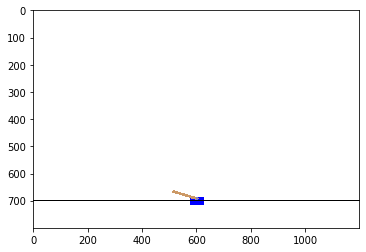

In [14]:
nb_episodes = 1
nb_timesteps = 300
img = plt.imshow(env.render(mode='rgb_array')) # only call this once

max_reward = 0

#np.random.seed()
env = env.unwrapped
for state in sample_states:
    #env.state = init_states_S[np.random.randint(0,len(init_states_S))]

    env.state = state
    for episode in range(nb_episodes):  # iterate over the episodes
        state = env.reset()             # initialise the environment
        rewards = []

        for t in range(nb_timesteps):    # iterate over time steps
            #env.render()                 # display the environment
            img.set_data(env.render(mode='rgb_array')) # just update the data
            display.display(plt.gcf())
            display.clear_output(wait=True)
            action = policy.label_ranking_policy(obs)
            observation, reward, done, info = env.step(np.array([[+1]]))
            obs = observation
            rewards.append(reward)      # add 1 to the rewards list

            if done: # the episode ends either if the pole is > 15 deg from vertical or the cart move by > 2.4 unit from the centre
                cumulative_reward = sum(rewards)
                print("episode {} finished after {} timesteps. Total reward: {}".format(episode, t+1, cumulative_reward)) 
                max_reward = max(max_reward,sum(rewards))
                break
    
    break
    env.close()

print(max_reward)

In [16]:
######################################
### Evaluating the learned policy ####

def run_evaluations(policy               # input policy
                    , state_list         # list of initial states
                    , step_thresh = 100    # step-count (threshold)
                    , env_name ='CartPole_PbPI_Version-v0' # name of the environment
                    , simulations_per_state = 100 # number of simulations to generate per state
                   ):  
    
    """
    Description:
    
        - For every state in a given list of initial states, 100 simulations are generate and the percentage of
           these simulations that exceeds a predefined step-count threadhold (trajectory length) is computed to measure 
           the performance of the given input policy."""
    

    simu_per_state = simulations_per_state
        
    # create an environment instance
    env_test = gym.make(env_name)
    env_test = env_test.unwrapped
    
    # variable to record the sufficient policy count (across all simulations)
    suf_policy_count = 0
    
    # iterate over all states in the state list
    for state in state_list:        
        
        # generate 100 simulations from each state
        for _ in range(simu_per_state):
            
            # set the starting state and the current observation to the given state 
            env_test.state, obs = state, state
        
            # variable to store the return of an episode
            return_ep = 0 

            # execute 1001 steps in the environment
            for _ in range(1001):
                action = policy.label_ranking_policy(obs) # generate action from the policy
                observation, reward, done, info = env_test.step(action) # execute action
                obs = observation     # set history
                return_ep += reward   # compute return
                if done: break

            env_test.reset()
            env_test.close()

            # increment the sufficient policy count if return exceeds given threshold
            # (note: at every step, 1 reward is produced in the environment)
            if return_ep>=step_thresh:
                suf_policy_count += 1
                
    # return the aggregated sufficient policy count from the policy evaluation
    return (suf_policy_count/(len(state_list)*simu_per_state))

#######################################

In [17]:
run_evaluations(policy, sample_states , step_thresh=150)

0.0

---